# Описание задачи
## В задачи пректа входит:

 - Обработка предоставленных данных: нахождение и заполнение пропусков, кодировка, нормализация признаков.
 - Привлечение дополнительных данных для обогащения датасета.
 - Создание новых признаков с использованием для этого как предоставленных данные так и дополнительно привлченных.
 - Обучение и тестирование модели на полученных признаках с применением обучающей и валидационной части данных
 - Отбор полезных признаков с использованием обученной модели, обучение модели на отобранных признаках
 - Получение предсказанных моделью значений, подготовка и отправка submission. 

## Описание датасета
Первоначальная версия датасета состоит из десяти столбцов, содержащих следующую информацию:

 - **Restaurant_id** — идентификационный номер ресторана / сети ресторанов;
 - **City** — город, в котором находится ресторан;
 - **Cuisine Style** — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
 - **Ranking** — место, которое занимает данный ресторан среди всех ресторанов своего города;
 - **Rating** — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
 - **Price Range** — диапазон цен в ресторане;
 - **Number of Reviews** — количество отзывов о ресторане;
 - **Reviews** — данные о двух отзывах, которые отображаются на сайте ресторана;
 - **URL_TA** — URL страницы ресторана на TripAdvosor;
 - **ID_TA** — идентификатор ресторана в базе данных TripAdvisor.



# Импорт библиотек, установка параметров, определение функций

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import scipy
import requests
import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

import os

In [2]:
# функции используемые в ноутбуке

def pre_process(df):
    '''
    реализация предобработки датасета из учебного проекта о_вкусной_и_здоровой_пище
    
    Parameters
    ---------
    df: pd.DataFrame
        датафрейм для предобработки  
    
    Returns
    -------  
    pd.DataFrame
        содержит предобработанные признаки: City, Cuisine Style, Ranking, Price Range,
        Number of Reviews, ID_TA
    
    Notes
    -----
    признак Restaurant_id функцией не обрабатывается ввиду неинформативности
    признак Reviews функцией не обрабатываетсмя ввиду не использования признака непосредственно,
        информация признака используется для создания нескольких новых признаков отдельно.
    '''
    import warnings
    warnings.filterwarnings("ignore")

    # предобработка признака City
    df = pd.concat([df,pd.get_dummies(df.City)],axis=1)

    # предобработка признака Cuisine Style
    df['Cuisine_Style_NaN'] = df.Cuisine_Style.isna().astype(int8)
    df.Cuisine_Style = df.Cuisine_Style.fillna("['Nan_Style']").str[2:-2].str.split("', '")
    cuisine_styles = sorted(set(df.Cuisine_Style.sum()))
    for style in cuisine_styles:
        df[style] = df.Cuisine_Style.apply(lambda x: int(style in x))

    # предобработка признака Ranking
    scaler = MinMaxScaler()
    grouped_by_City = df.groupby('City')
    for group in grouped_by_City.groups:
        index = grouped_by_City.groups[group]
        scaled_values = scaler.fit_transform(df[['Ranking']].loc[index])
        df.Ranking.loc[index] = pd.Series(scaled_values.flatten(), index=index)
    
    # предобработка признака Price Range
    df['Price_Range_NaN'] = df.Price_Range.isna().astype(int8)
    price_range_encod = {'$': 1, '$$ - $$$': 2, '$$$$': 3}
    df['Price_Range_enc'] = df.Price_Range.map(price_range_encod)
    df.Price_Range_enc.fillna(df.Price_Range_enc.mean(),inplace=True)

    # предобработка признака Number of Reviews
    df['NoR_NaN'] = df.Number_of_Reviews.isna().astype(int8)
    df.Number_of_Reviews.fillna(1,inplace=True)
    scaler = MinMaxScaler()
    for group in grouped_by_City.groups:
        index = grouped_by_City.groups[group]
        scaled_values = scaler.fit_transform(df[['Number_of_Reviews']].loc[index])
        df.Number_of_Reviews.loc[index] = pd.Series(scaled_values.flatten(), index=index)

    # предобработка признака ID_TA
    df.ID_TA = df.ID_TA.str[1:].astype(int)
    
    # предобработка признака URL_TA
    df['g_id'] = df.URL_TA.apply(lambda x: int(x[x.find('-g')+2: x.find('-',x.find('-g')+2)]))
    
    return df

def get_cuisine_styles(row):
    '''
    получение списка уникальных наименований стиля кухни, встречающихся в колонке Cuisine_Style
    
    Parameters
    ---------
    row: pd.Series, str
        содержит названия стилей кухни в ресторане в виде строкового представления списка 
        (формат "['Стиль_1', 'Стиль_2', ..., 'Стиль_N']")
    
    Returns
    -------  
    list, str
        список уникальных наименований стиля кухни, встречающихся в колонке Cuisine_Style             
    '''     
    return sorted(set(row.fillna("['Nan_Style']").str[2:-2].str.split("', '").sum()))

def get_review_texts(row):
    '''
    извлечение текста отзыва/ов из признака Reviews
    
    Parameters
    ---------
    row: pd.Series, str
        содержит текст отзыва/ов в формате "[['текст/-ы_отзыва/-ов'], [...]]"
    
    Returns
    -------  
    pd.Series, str
        текст/-ы отзыва/ов из признака Reviews 
    '''
    return row.apply(lambda x:x[: x.find('], [')+1]).str.replace("[\[\]]", "")
    
def get_review_date_lists(row):
    '''
    извлечение в строковом виде даты отзыва/-ов из признака Reviews
    
    Parameters
    ---------
    row: pd.Series, str
        содержит дату отзыва/ов в формате "[[...], ['дата/-ы_отзыва/-ов']]"
    
    Returns
    -------  
    pd.Series, str
        дата/-ы отзыва/ов из признака Reviews              
    '''
    return row.apply(lambda x:x[ x.find('], [')+3:]).str.replace("[\[\]' ]", "").str.split(",")

def get_rest_names(row):
    '''
    извлечение названия ресторана из  из признака URL_TA
    
    Parameters
    ---------
    row: pd.Series, str
        содержит название ресорана в формате "...-Reviews-НАЗВАНИЕ_РЕСТОРАНА-..."
    
    Returns
    -------  
    pd.Series, str
        названия ресторана из  из признака URL_TA              
    ''' 
    return row.apply(lambda x: x[x.find('Reviews-')+8: x.find('-',x.find('Reviews-')+8)])

In [3]:
# установка параметров
%pylab inline

pd.set_option('display.max_rows', 50) # выведем больше строк
pd.set_option('display.max_columns', 30) # выведем больше колонок

# альтернативные пути на kaggle и локальный (НЕ ЗАБЫТЬ МЕНЯТЬ!)
path = './Preproject3_data/'
# path = '/kaggle/input/sf-dst-restaurant-rating/'

# url-ы файов с позитивной и негативной английской лексикой 
pos_url = \
'https://gist.githubusercontent.com/mkulakowski2/4289437/raw/1bb4d7f9ee82150f339f09b5b1a0e6823d633958/positive-words.txt'
neg_url = \
'https://gist.githubusercontent.com/mkulakowski2/4289441/raw/dad8b64b307cd6df8068a379079becbb3f91101a/negative-words.txt'

RANDOM_SEED = 42

Populating the interactive namespace from numpy and matplotlib


In [4]:
# проверка пути и имен файлов
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./Preproject3_data/kaggle_task.csv
./Preproject3_data/main_task.csv
./Preproject3_data/sample_submission.csv


In [5]:
# чтение данных
df_train = pd.read_csv(f'{path}main_task.csv')
df_test = pd.read_csv(f'{path}kaggle_task.csv')
sample_submission = pd.read_csv(f'{path}sample_submission.csv')

# Ознакомление с данными

Для корректной обработки признаков объединяем трейн и тест в один датасет ***data***

In [6]:
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

Теперь посмотрим на полученный датасет

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [8]:
display(data.sample(5))
print()
for col in data.columns: print('{:20} {}'.format(col, type(data.loc[0][col])))

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
21569,id_4698,Madrid,['Spanish'],4701.0,$$ - $$$,5.0,"[[], []]",/Restaurant_Review-g187514-d7368884-Reviews-Lo...,d7368884,1,4.5
3085,id_3085,Rome,"['Italian', 'Steakhouse', 'Pizza', 'Mediterran...",1355.0,$$ - $$$,647.0,"[['Well worth a visit', 'A good choice'], ['10...",/Restaurant_Review-g187791-d1950660-Reviews-Ga...,d1950660,0,0.0
47907,id_2226,Amsterdam,"['Dutch', 'European']",2231.0,$,NaN,"[['Great coffee and breakfast'], ['12/02/2017']]",/Restaurant_Review-g188590-d13171238-Reviews-2...,d13171238,1,5.0
37556,id_7772,London,"['Pizza', 'Italian']",7781.0,$,26.0,"[['Good Value Pizza', 'Very nice pizza'], ['12...",/Restaurant_Review-g186338-d7589191-Reviews-Pi...,d7589191,1,4.0
27493,id_9842,Paris,['Middle Eastern'],9844.0,$$ - $$$,52.0,"[['Ali', 'Beautiful Paris!'], ['01/21/2017', '...",/Restaurant_Review-g187147-d2659008-Reviews-Le...,d2659008,1,3.5



Restaurant_id        <class 'str'>
City                 <class 'str'>
Cuisine Style        <class 'str'>
Ranking              <class 'numpy.float64'>
Price Range          <class 'str'>
Number of Reviews    <class 'numpy.float64'>
Reviews              <class 'str'>
URL_TA               <class 'str'>
ID_TA                <class 'str'>
sample               <class 'numpy.int64'>
Rating               <class 'numpy.float64'>


Пропуски в явном виде *(NaN)* наблюдаются в четырех признаках: `Cuisine Style`, `Price Range`, `Number of Reviews` и `Reviews`. Кроме трех числовых признаков `Ranking`, `Rating` и `Number of Reviews`(один из них, `Rating` - целевая переменная) и одного вспомогательного временного столбца `sample` признаки представлены строками.

Изменеим имена колонок для возможности обращения к колонкам как к атрибутам DataFrame

In [9]:
data.columns = data.columns.str.replace(' ','_')

# Работа с предоставленными данными

Сначала рассмотрим существующие признаки, выберем способы их предобработки, извлечем из существующих признаков информацию для создания новых.  
Затем предобработаем существующие признаки согласно выбранным способам.  
После этого создадим новые, при необходимости предобработаем и их.

### Restaurant_id
Согласно описанию - идентификационный номер ресторана / сети ресторанов   

Посмотрим на значения признака

In [10]:
data.Restaurant_id.sample(5)

15243      id_10
22343    id_1598
34010    id_1984
7346     id_7346
41049    id_4490
Name: Restaurant_id, dtype: object

Значения признака строковые, формата **'id_ЧИСЛО'**, где **ЧИСЛО** - некоторое целое число.
Проверим, все ли значения выглядит подобным образом, для этого убедимся что первые три символа везде **'id_'** и что все значения после первых 3-х симвлов содержат только цифры:

In [11]:
(data.Restaurant_id.str[:3] == 'id_').all(), data.Restaurant_id.str[3:].str.isnumeric().all()

(True, True)

Всё так и есть. Можно отбросить первые три символа(они везде одинаковые и потому не несут никакой информации) и в качестве значения признака принять приведенное к числовому виду **ЧИСЛО**:

Сопоставление `Restaurant id` с другими признаками из набора данных для обучения показало что как правило `Ranking` и **ЧИСЛО** в `Restaurant id` либо совпадают с точностью до 1 либо очень близки (возможно **ЧИСЛО** это `Ranking` в момент внесения ресторана в набор данных). Это наблюдение делает информативным казалось бы бесполезный признак.  
UPD: Однако изучение набора данных для получения предсказания (Submission) показало, что в этих данных такая взаимосвязь отсутсвует. Вероятно оригигальные значения `Restaurant_id` были заменены. "Казалось бы бесполезный признак" не кажется таковым, он и вправду бесполезен для модели.

Пропусков в признаке нет.

### City
Согласно описанию - город, в котором находится ресторан   

Посмотрим на значения признака и заодно проверим, есть ли пропуски в неявном виде:

In [12]:
data.City.unique()

array(['Paris', 'Helsinki', 'Edinburgh', 'London', 'Bratislava', 'Lisbon',
       'Budapest', 'Stockholm', 'Rome', 'Milan', 'Munich', 'Hamburg',
       'Prague', 'Vienna', 'Dublin', 'Barcelona', 'Brussels', 'Madrid',
       'Oslo', 'Amsterdam', 'Berlin', 'Lyon', 'Athens', 'Warsaw',
       'Oporto', 'Krakow', 'Copenhagen', 'Luxembourg', 'Zurich', 'Geneva',
       'Ljubljana'], dtype=object)

Пропусков, выбросов нет. Остается привести признак в числовой вид, применив dummy-кодирование.

### Cuisine_Style
согласно описанию - кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане.  

Посмотрим как устроен признак:

In [13]:
data.Cuisine_Style.sample(5,random_state=RANDOM_SEED)

33553                                          ['Italian']
9427                                                   NaN
199      ['Middle Eastern', 'Vegetarian Friendly', 'Veg...
12447                                                  NaN
39489                                                  NaN
Name: Cuisine_Style, dtype: object

Сначала создадим признак `Cuisine_Style_NaN` - наличие/отсутствие пропуска в признаке.

Затем заполним пропуски в признаке строковым значением *['Nan_Style']* и после этого преобразуем строковое представление списков непосредственно в списки.

После чего мы создадим dummy-признаки по значениям в списках полученных из строковых значений в `Cuisine_Style` 

Сохраним список всех таких значений(наименований кухни), встречающихся в в `Cuisine_Style`, этот список нам понадобится в дальнейшем:

In [14]:
%%time
cuisine_styles = get_cuisine_styles(data.Cuisine_Style)

Wall time: 22.3 s


Проверим, не было ли в признаке пропусков в неявном виде (т.е. в виде пустых строк, строкового представления пустого списка и т.д.). Если это так, то в `cuisine_styles` должна оказаться пустая строка.

In [15]:
'' in cuisine_styles

False

### Ranking
Согласно описанию - место, которое занимает данный ресторан среди всех ресторанов своего города

Признак числовой.  
Пропусков нет

В каждом городе разное количество ресторанов, поэтому и диапозон `Ranking` в каждом городе различный (что приводит к тому что наихудший ресторан в маленьком городе будет иметь такой же `Ranking` как и отличный ресторан в мегаполисе). Такая разница масштабов может помешать модели, имеет смысл отнормировать  Ranking в каждом городе отдельно, что мы и сделаем. 

Так же можно использовать как оценку количества ресторанов в городе максимальную величину `Ranking` для каждого города. Эта величина будет использована как самостоятельный признак и будет участвовать в создании других новых признаков.

Сохраним оценку количества ресторанов в городе, она нам понадобится при создании новых признаков.

In [16]:
num_rest_estimate = data.groupby('City').Ranking.max() 

### Price_Range
Согласно описанию - диапазон цен в ресторане   

Посмотрим на значения признака:

In [17]:
data.Price_Range.unique()

array(['$$ - $$$', '$$$$', '$', nan], dtype=object)

Сначала создадим бинарный признак `Price_Range_NaN` -  наличие (1) или отсутствие (0) пропуска в признаке.

Затем приведем признак к числовому виду, сперва закодировав каждый из трех вариантов не-NaN значений соответствующим числом от 1 (для низкого ценового диапозона) до 3 (для высокого ценового диапзона), а затем заполнив пропуски средним арифметическим уже закодированных непустых ячеек.

### Number_of_Reviews
Согласно описанию - количество отзывов о ресторане  

Признак в числовой форме.
Пропуски в признаке есть:

In [18]:
data.Number_of_Reviews.isna().sum()

3200

Посмотрим на распределение признака в области 0:

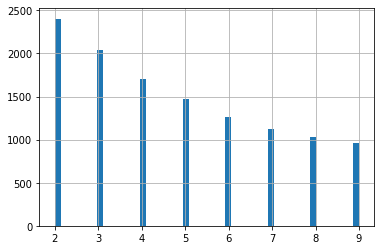

In [19]:
data.Number_of_Reviews[data.Number_of_Reviews<10].hist(bins = 50);

Перед заполнением пропуска создадим бинарный признак наличия/отсутствия значения в признаке , обозначим его `NoR_NaN`. 

Если сопоставить количество пропусков и распределение, то может возникнуть предположение, что пропуски подразумевают значение 0 или 1. Такая версия не испортит общий вид распределения. Заполнение пропусков 1 в отличии от заполнения 0 упростит использование данного признака при создании признаков новых (на случай если вдруг появится идея поделить на `Number_of_Reviews`) .Поэтому заполним пропуски 1. Этим обработка признака и ограничится.

### ID_TA
Согласно описанию - идентификатор ресторана в базе данных TripAdvisor

Посмотрим на значения признака:

In [20]:
data.ID_TA[:5]

0    d10746918
1     d6674944
2    d13129638
3      d680417
4     d1112354
Name: ID_TA, dtype: object

Значения признака строковые, формата **'dЧИСЛО'**, где **ЧИСЛО** - некоторое целое число. Проверим, все ли значения выглядит подобным образом, для этого убедимся что первый символ везде 'd' и что все символы кроме первого - только цифры:

In [21]:
(data.ID_TA.str[0] == 'd').all(), (data.ID_TA.str[1:].str.isnumeric()).all()

(True, True)

Обработаем признак -  примем в качесвте значения приведенную к числовому виду его цифровая часть (т.е. **ЧИСЛО**).  
В работе будет использоваться гипотеза о том что цифровая часть отражает хронологический порядок появления ресторана в базе данных. 

### Reviews
Согласно описанию - данные о не более чем двух последних отзывах, которые отображаются на сайте ресторана  

Посмотрим на значения признака:

In [22]:
data.Reviews[:5]

0                                             [[], []]
1    [['Very good reviews!', 'Fine dining in Hakani...
2    [['Better than the Links', 'Ivy Black'], ['12/...
3    [['Most exquisite', 'Delicious and authentic']...
4    [['Always the best in bratislava', 'Very good ...
Name: Reviews, dtype: object

Признак строковый,в нем есть неявные пропуски (значения "[[], []]"), при работе с признаком надо будет учитывать их наличие. Удалять наблюдения с такими значениями не следует ввиду их значительного количества:

In [23]:
(data.Reviews == '[[], []]').sum()

8112

In [24]:
print('В признаке пропусков в явном виде {}, заполним их строковым значением "[[], []]"'.format(data.Reviews.isna().sum()))
data.Reviews.fillna('[[], []]',inplace=True)

В признаке пропусков в явном виде 2, заполним их строковым значением "[[], []]"


При работе с  признаком:
 - отделим и сохраним текстовую составляющую (собственно отзывы)
 - получим список дат отзывовов.   
 На основе этой информации позднее создадим новые признаки.

In [25]:
Review_texts = get_review_texts(data.Reviews)

In [26]:
review_date_lists = get_review_date_lists(data.Reviews)

### URL_TA
Согласно описанию - URL страницы ресторана на TripAdvosor  

Посмотрим на значения признака:

In [27]:
for s in data.URL_TA[:5]: print(s)

/Restaurant_Review-g187147-d10746918-Reviews-Le_Perchoir-Paris_Ile_de_France.html
/Restaurant_Review-g189934-d6674944-Reviews-Ravintola_Kolmon3n-Helsinki_Uusimaa.html
/Restaurant_Review-g186525-d13129638-Reviews-Black_Ivy-Edinburgh_Scotland.html
/Restaurant_Review-g186338-d680417-Reviews-Quirinale-London_England.html
/Restaurant_Review-g274924-d1112354-Reviews-Massimo_Ristorante-Bratislava_Bratislava_Region.html


Значения строковые, в строке присутсвует индентификатор формата 'g123456'(сопоставление с другими признаками показало что это ID города), затем ID_TA, название ресторана, город/регион.  
Получим название и попытаемся такой признак обработать и применить.

In [28]:
rest_names = get_rest_names(data.URL_TA)

Так же получим числовую часть индентификатора вида 'g123456' - возможно в ID города в TripAdvisor содержится 
какая-то информация (создадим отельный признак `g_id`)

## Реализация предобработки.
Проведем кодирование существующих признаков в соотвтетсвии с принятыми решениями о способах предобработки.

In [29]:
%%time
data = pre_process(data)

Wall time: 25.7 s


Посмотрим на максимальные корреляции признаков с целевой переменной (поскольку значительная часть признаков бинарные, то абсолютные значения корреляция Пирсона не очень информативны - тем не менее некотрое представление о нличии взаимосвзяи они дать могут)

In [30]:
data.corr().Rating.abs().sort_values(ascending=False).drop(['Rating','sample'])[:20]

Rating                 1.000000
sample                 0.936543
Ranking                0.168798
ID_TA                  0.049589
Vegetarian Friendly    0.037317
Vegan Options          0.029015
Rome                   0.027527
Gluten Free Options    0.025691
Healthy                0.023766
Milan                  0.023233
Delicatessen           0.021144
Chinese                0.021039
Price_Range_NaN        0.020519
Mediterranean          0.018614
Wine Bar               0.017776
Athens                 0.016852
Madrid                 0.016232
European               0.016217
Vietnamese             0.013444
Berlin                 0.012834
Name: Rating, dtype: float64

# Создание новых признаков

Новый признак `population` - население города, в которм расположен ресторан. Признак возможно интресен и сам по себе, но с большей вероятнотью интересен в сочетании с другими признаками.

In [31]:
population = pd.Series({
    'Paris':2140526, 'Stockholm':961609, 'London': 8787892, 'Berlin':3601131, 'Munich':1456039, 
    'Oporto':240000,'Milan':1366180, 'Bratislava': 425923, 'Vienna':1840573, 'Rome': 2872800, 
    'Barcelona':1620343, 'Madrid':3223334,'Dublin':553165, 'Brussels':1198726, 'Zurich': 428000, 
    'Warsaw':1758143, 'Budapest':1749734, 'Copenhagen':615993,'Amsterdam':859732, 'Lyon':515695, 
    'Hamburg':1830584, 'Lisbon':506654, 'Prague':1280508, 'Oslo':673469,'Helsinki':643272, 
    'Edinburgh':524900 ,'Geneva':499000, 'Ljubljana':258900, 'Athens':655780, 'Luxembourg':115227, 
    'Krakow':766739
})

data['City_population'] = data.City.map(population)

Новый признак `tourist_arrival` количество постивших город туритсов.

In [32]:
tourist_arrival = pd.Series({
    'London': 19059500, 'Paris': 13926300,'Rome':  9353900,'Prague':  8200600,'Amsterdam':  6898600, 
    'Barcelona':  6515500, 'Milan':  6175000,'Vienna':  5867600,'Berlin':  5559600,'Madrid':  5131700,
    'Dublin':  4810000,'Athens':  4526000,'Munich':  3389300,'Budapest':  3511400,'Lisbon':  3136100,
    'Brussels':  2511500,'Copenhagen':  2887700,'Warsaw':  2733000,'Krakow':  2650000,
    'Stockholm':  2327000,'Oporto':  1969300,'Bratislava': 986201,'Lyon': 1700000,'Hamburg': 2713200,
    'Luxembourg': 1018000,'Ljubljana':  1022862,'Edinburgh': 3300000,'Helsinki': 1700000,'Oslo': 1352112,
    'Zurich': 2000000,'Geneva': 2200000
})

data['tourist_arrival'] = data.City.map(tourist_arrival)

Новый признак `tourist_population_prop` - отношение прибывших туристов к населению города

In [33]:
tourist_population_prop = tourist_arrival/population
data['tourist_population_prop'] = data.City.map(tourist_population_prop)

Новый признак `styles_num` - количество стилей кухни, представленных в ресторане.

In [34]:
data['styles_num'] = data.apply(lambda x: 0 if x.Nan_Style else len(x.Cuisine_Style),axis=1)

Новый признак `num_rest_estimate` оценка количества ресторанов в городе (оценкой служит Ranking.max())

In [35]:
data['num_rest_estimate'] = data.apply(lambda x: num_rest_estimate[x.City], axis = 1)

Новый признак `rest_per_capita` -  оценочное (по Ranking.max()) количество ресторанов на душу населения.

In [36]:
data ['rest_per_capita'] = data.apply(lambda x: num_rest_estimate[x.City]/x.City_population, axis = 1)

Новый признак `reviews_per_capita` - количество отзывов на душу населения

In [37]:
data['reviews_per_capita']=data.Number_of_Reviews/data.City_population

Новый признак `since_review` - время прошедшее с даты последнего отзыва

In [38]:
str_to_data = lambda x: datetime.datetime.strptime(x, '%m/%d/%Y').date() # функция перевода str в datetime
today = datetime.datetime.today().date()

data['since_review'] = review_date_lists.apply(lambda x: (today - str_to_data(x[-1])).days if x[-1] 
                                             else -999)

Новый признак `review_date_range` временной интервал между отзывами

In [39]:
data['review_date_range'] = review_date_lists.apply(lambda x: (str_to_data(x[0]) - str_to_data(x[1])).days if len(x) == 2 
                                                  else 0)

Новый признак `rank_dif_NoR` - разница в рангах отранжированного количества отзывов ***Number_of_Reviews*** и отранжированных по цифрой части ***ID_TA***, основан на предположении, что ***ID_TA*** заполнялся в хронологическом порядке и предположении, что чем дольше ресторан работает, тем больше должно быть отзывов.

In [40]:
NoR_index = data.Number_of_Reviews[data.Number_of_Reviews != 0].index

ID_TA_with_NoR = data.loc[NoR_index].ID_TA

NoR_rank_dict = {val: rank for rank, val in enumerate(sorted(data.Number_of_Reviews[NoR_index],reverse=True))}
NoR_rank = data.Number_of_Reviews[NoR_index].map(NoR_rank_dict)

ID_TA_NoR_rank_dict = {val: rank for rank, val in enumerate(sorted(ID_TA_with_NoR))}
ID_TA_NoR_rank = ID_TA_with_NoR.map(ID_TA_NoR_rank_dict)

data['rank_dif_NoR'] = ID_TA_NoR_rank - NoR_rank
data.rank_dif_NoR.fillna(0, inplace=True)

Новый признак `rev_text_length` - длинна извлеченного из `Reviews` текста отзыва(-ов).

In [41]:
data['rev_text_length'] = Review_texts.apply(len)

Новый признак `rev_on_website` - количество отзывов на сайте, согласно признаку `Reviews`

In [42]:
data['rev_on_website'] = Review_texts.apply(lambda x: len(x.split(', ')) if x else 0)

Новый признак `punct_in_review` - бинарный признак наличия/отсутствия знаков пунктуации в тектсе отзыва(-ов)

In [43]:
punct = "!;:?.,"
data['punct_in_review'] = Review_texts.apply(lambda x: int(bool(set(list(punct)) & set(list(x.replace(', ',''))))))

Новый признак `Name_lenght` длина названия в символах. Предположительно хорошие рестораны имеют более претенциозные названия, вероятно - более длинные, чем названия простецких забегаловок.

In [44]:
data['Name_lenght'] = rest_names.apply(len)

Новый признак `words_in_name` длина названия в словах. Идея признака та же, что и у `Name_lenght`

In [45]:
data['words_in_name'] = rest_names.str.split('_').apply(len)

Новый признак `is_capital`

In [46]:
is_capital_dict = {
    'Paris':1, 'Stockholm':1, 'London': 1, 'Berlin':1, 'Munich':0, 
    'Oporto':0,'Milan':0, 'Bratislava': 1, 'Vienna':1, 'Rome': 1, 
    'Barcelona':0, 'Madrid':1,'Dublin':1, 'Brussels':1, 'Zurich': 0, 
    'Warsaw':1, 'Budapest':1, 'Copenhagen':1,'Amsterdam':1, 'Lyon':0, 
    'Hamburg':0, 'Lisbon':1, 'Prague':1, 'Oslo':1,'Helsinki':1, 
    'Edinburgh':0 ,'Geneva':0, 'Ljubljana':1, 'Athens':1, 'Luxembourg':1, 
    'Krakow':0
}

data['is_capital'] = data.City.map(is_capital_dict)

Введем величину `uniqueness_of_cuisine` - это величина обратная тому, сколько раз кухня встречается в наборе данных.  
`uniqueness_of_cuisine` принимает значения в интервале (0, 1] (значения стремящиеся к 0 - кухня встречается очень часто, 1 - кухня встречется всего 1 раз)

In [47]:
total_cuistyle_list = data.Cuisine_Style.sum()    
uniqueness_of_cuisine = 1/pd.Series(total_cuistyle_list).value_counts()

Новый признак `sum_uniqueness` - сумма уникальностей стилей кухни ресторана

In [48]:
sum_uniqueness = lambda x: uniqueness_of_cuisine[x].sum()
data['sum_uniqueness'] = data.Cuisine_Style.apply(sum_uniqueness)

Новый признак `max_uniqueness` - максимальная уникальность кухни в ресторане

In [49]:
max_uniqueness = lambda x: uniqueness_of_cuisine[x].max()
data['max_uniqueness'] = data.Cuisine_Style.apply(max_uniqueness)

Новый признак `min_uniqueness` - минимальная уникальность (т.е. максимальная распрстранненность, популярность) кухни в ресторане

In [50]:
min_uniqueness = lambda x: uniqueness_of_cuisine[x].min()
data['min_uniqueness'] = data.Cuisine_Style.apply(min_uniqueness)

Введем величину `city_uniqueness_of_cuisine` - аналогично `uniqueness_of_cuisine`, только применительно к каждому городу отдельно. С помощью этой величины создадим три новых признака `city_sum_uniqueness` ,`city_max_uniqueness` и `city_min_uniqueness`

In [51]:
%%time
grouped_by_City = data.groupby('City')

city_sum_uniqueness = lambda x: city_uniqueness_of_cuisine[x].sum()
city_max_uniqueness = lambda x: city_uniqueness_of_cuisine[x].max()
city_min_uniqueness = lambda x: city_uniqueness_of_cuisine[x].min()

temp_city_sum = pd.Series()
temp_city_max = pd.Series()
temp_city_min = pd.Series()

for group in grouped_by_City.groups:
    index = grouped_by_City.groups[group]
    
    city_cuistyle_list = data.Cuisine_Style.loc[index].sum()    
    city_uniqueness_of_cuisine = 1/pd.Series(city_cuistyle_list).value_counts()
    
    temp_city_sum = temp_city_sum.append(data.Cuisine_Style.loc[index].apply(city_sum_uniqueness)) 
    temp_city_max = temp_city_max.append(data.Cuisine_Style.loc[index].apply(city_max_uniqueness))  
    temp_city_min = temp_city_min.append(data.Cuisine_Style.loc[index].apply(city_min_uniqueness))
    
data['city_sum_uniqueness'] = temp_city_sum
data['city_max_uniqueness'] = temp_city_max
data['city_min_uniqueness'] = temp_city_min

Wall time: 1min


Введем новую величину распрастранненость/популярность кухни `prevalence_of_cuisine` определим её как ***1 - uniqueness_of_cuisine***.  
`prevalence_of_cuisine` принимает значения в интервале [0, 1) (0 - кухня встречается всего  1 раз, значения стремящиеся к 1 - кухня крайне распространена)

In [52]:
prevalence_of_cuisine = 1 - uniqueness_of_cuisine

Новый признак `sum_prevalence` - сумма распрастраннености стилей кухни ресторана

In [53]:
sum_prevalence = lambda x: prevalence_of_cuisine[x].sum()
data['sum_prevalence'] = data.Cuisine_Style.apply(sum_prevalence)

Создадим анологичный признак для каждого города - `city_sum_prevalence`

In [54]:
%%time
grouped_by_City = data.groupby('City')

city_sum_prevalence = lambda x: city_prevalence_of_cuisine[x].sum()

temp_city_sum = pd.Series()

for group in grouped_by_City.groups:
    index = grouped_by_City.groups[group]
    
    city_cuistyle_list = data.Cuisine_Style.loc[index].sum()    
    city_prevalence_of_cuisine = 1 - 1/pd.Series(city_cuistyle_list).value_counts()
    
    temp_city_sum = temp_city_sum.append(data.Cuisine_Style.loc[index].apply(city_sum_prevalence)) 
    
data['city_sum_prevalence'] = temp_city_sum

Wall time: 23.4 s


Новый признак - тональность отзыва/-ов `review_sentiment`

In [55]:
pos_req = requests.get(pos_url)
neg_req = requests.get(neg_url)

pos_words = pos_req.text[pos_req.text.find('abound'):].strip().split('\n')
neg_words = neg_req.text[neg_req.text.find('abnormal'):].strip().split('\n')

Review_words = Review_texts.replace(to_replace=r'\W',value = ' ',regex=True).str.lower().str.split()

review_sentiment = lambda x: sum([int(w in pos_words) for w in x]) - sum([int(w in neg_words) for w in x])

data['review_sentiment']    = Review_words.apply(review_sentiment).fillna(0)

Передадим модели некоторые особенности распределений целевой переменной в каждом городе 
(потенциально чревато переобучением, проверим на валидационной части выборки не просело ли качество)

In [56]:
data['city_median_rating'] = data.City.map(grouped_by_City.Rating.median())

data['city_mean_rating'] = data.City.map(grouped_by_City.Rating.mean())

data['city_rating_skewness'] = data['city_mean_rating'] - data['city_median_rating']

# Завершение подготовки данных для обучения модели

Удалим те столбцы что более не нужны для создания новых признаков и при этом мы не собираемся их передавать модели 

In [57]:
coltodrop = ['Restaurant_id','City', 'Reviews', 'URL_TA', 'Price_Range','Cuisine_Style']
enrichmented_data = data.drop(columns=coltodrop)

Несколько строк проверки корректности обработки данных

In [58]:
enrichmented_data.dtypes[enrichmented_data.dtypes == object]

Series([], dtype: object)

In [59]:
enrichmented_data.isna().sum().sum()

0

In [60]:
enrichmented_data.shape

(50000, 195)

В самом начале мы для корректной обработки признаков объединили два исходных датсета в один. Теперь обратно разделим данные на часть для обучения и тестирования модели и часть для получения предсказания (Submission)  и удалим внесенные нами для удобства обработки колонки.

In [61]:
train_data = enrichmented_data.query('sample == 1').drop(['sample'], axis=1)
test_data = enrichmented_data.query('sample == 0').drop(['sample','Rating'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.  

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

Еще раз проверяем размерности полученных датасетов

In [63]:
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 193), (40000, 194), (40000, 193), (32000, 193), (8000, 193))

# Создаём, обучаем и тестируем модель
## Первичное обучение и тестирование

In [64]:
%%time
# Создаём модель
regr = RandomForestRegressor(n_estimators=100, random_state = RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

Wall time: 1min 3s


Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются  
Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.

In [65]:
print('MAE:', metrics.mean_absolute_error(y_pred, y_test))

MAE: 0.197031875


Искомые значения рейтинга дискретны - от 1 до 5 с шагом 0.5, наверное имеет смысл округлить полученные результаты 
до этих значений

In [66]:
print('MAE:', metrics.mean_absolute_error((y_pred*2).round()/2, y_test))

MAE: 0.162


Что ж, мы получили уже неплохой результат. Но не станем останавливаться и попробуем еще хоть немного продвинуться вперед .

## Отбор неполезных признаков
Обучив модель, мы теперь можем попытаться улучшить наш датасет отбросив те признаки , которые ухудшают метрику на валидационной части выборки, расчитывая на то что это улучшит точность работы модели на данных для Submission.  
Мы последовательно будем изымать по одному признаку из датасета и проверять как изменилась метрика (будем сравнивать с MAE при полном датасете). Если значение MAE улучшилось в отсутсвии признака, то признак будет отнесен к неполезным.

In [67]:
from tqdm import tqdm

MAE_threshold = metrics.mean_absolute_error(y_pred, y_test)

unuseful_features = pd.Series([])

for col in tqdm(X.columns):
    X_tmp = X.drop(columns=col)
    X_trn, X_tst, y_trn, y_tst = train_test_split(X_tmp, y, test_size=0.2, random_state=RANDOM_SEED)
    regr.fit(X_trn, y_trn)
    
    y_pr = regr.predict(X_tst)
    
    MAE_tmp = metrics.mean_absolute_error(y_pr, y_tst) 
    
    if MAE_tmp < MAE_threshold : 
        unuseful_features[col] = MAE_threshold - MAE_tmp

unuseful_features = unuseful_features.sort_values(ascending = False)
# unuseful_features.to_csv('unuseful_features')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [3:15:05<00:00, 60.65s/it]


В результате мы получили pd.Series `unuseful_features` c индексами - наименованием признака и значениями - уменьшением метрики МАЕ в отсутствии признака (т.е "вредом" от признака)

## Подбор оптимального количества исключаемых из датасета признаков
Получив неполезные признаки вместо того чтобы просто удалить их из датасета постараемся подобрать оптимальное количество удалямых признаков. Для этого станем удалять признаки по одному, начиная с признака с наибольшим "вредом" и будем следить за значениеми обычного МАЕ и МАЕ с использованием округдения предсказания до 0,5. 

In [68]:
MAE_changes = pd.DataFrame(columns=['MAE', 'MAE_round'])

for loc in tqdm(range(0,len(unuseful_features),1)):
    to_drop = unuseful_features.index[:loc]
    
    X_tmp = X.drop(columns=to_drop)
    X_trn, X_tst, y_trn, y_tst = train_test_split(X_tmp, y, test_size=0.2, random_state=RANDOM_SEED)
    regr.fit(X_trn, y_trn)
    
    y_pr = regr.predict(X_tst)
    
    MAE_tmp = metrics.mean_absolute_error(y_pr, y_tst) 
    MAE_round_tmp = metrics.mean_absolute_error((y_pr*2).round()/2, y_tst)
    MAE_changes.loc[loc] = [MAE_tmp,MAE_round_tmp]
#     print('{:3}  {:.6f}  {:.6f}'.format(loc, MAE_tmp,MAE_round_tmp))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [1:06:24<00:00, 43.31s/it]


Примем в качестве оптимального результата минимум суммы `MAE` и `MAE_round` и соответсвенно удалим из датасета количество признаков `optim_count` при удалении которого достигается такой миниум.

In [69]:
optim_count = MAE_changes.sum(axis=1).idxmin()

In [70]:
X_optim = X.drop(columns=unuseful_features.index[:optim_count])
X_trn, X_tst, y_trn, y_tst = train_test_split(X_optim, y, test_size=0.2, random_state=RANDOM_SEED)
regr.fit(X_trn, y_trn)

y_pr = regr.predict(X_tst)
    
MAE_optim = metrics.mean_absolute_error(y_pr, y_tst) 
MAE_round_optim = metrics.mean_absolute_error((y_pr*2).round()/2, y_tst) 

print(MAE_optim,MAE_round_optim)

0.19533625 0.16


# Submission
Применим обученную на оптимизированом нами датасете модель для получения предсказания на тестовых данных

In [71]:
test_data = test_data.drop(columns=unuseful_features.index[:optim_count])

In [72]:
predict_submission = regr.predict(test_data)

In [73]:
sample_submission['Rating'] = (predict_submission*2).round()/2
sample_submission.to_csv('submission_tmp.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,1.5
7,id_7,3.0
8,id_8,4.0
9,id_9,4.5


In [74]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 201 entries, Restaurant_id to city_rating_skewness
dtypes: float64(21), int32(1), int64(139), int8(3), object(6), uint8(31)
memory usage: 65.1+ MB
